<a href="https://colab.research.google.com/github/Stan-Leigh/traffic-signs-classification/blob/main/traffic_signs_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Import libraries**

In [1]:
import keras
from keras.models import Sequential # used to model a neural network
from keras.layers.convolutional import Conv2D, MaxPooling2D 
# Conv2D is used to extract the features from an image
# MaxPooling2d reduces the dimensionality of the data(image) without losing too much information
from keras.layers import Dense, Dropout, Flatten
# Dense ensures that each input node is connected to each output node in a neural network. It predicts the labels
# Dropout is used to avoid overfitting
# Flatten transforms a 2D matrix of features into a vector that can be fit into a neural network classifier
from keras.optimizers import Adam # used to compilr and optimize our model
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pickle
import numpy as np
import pandas as pd
import random

## **Import Dataset and Explore**

In [2]:
# cloning repo containing the traffic sign dataset
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), 117.80 MiB | 7.10 MiB/s, done.


In [3]:
# list dataset contents
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [4]:
# load the dataset
data = pd.read_csv('german-traffic-signs/signnames.csv')

In [5]:
data

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


In [6]:
# loading pickled dataset

with open('german-traffic-signs/train.p', mode='rb') as training:
  train = pickle.load(training)

with open('german-traffic-signs/valid.p', mode='rb') as validation:
  valid = pickle.load(validation)

with open('german-traffic-signs/test.p', mode='rb') as testing:
  test = pickle.load(testing)

In [7]:
X_train, y_train = train['features'], train['labels']
X_validation, y_validation = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [8]:
print(X_train.shape)
print(X_validation.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


For X_train, there are 34,799 images of 32 by 32 pixels. The last 3 means that the images are colored. Same applies for the remaining two.

image label=8


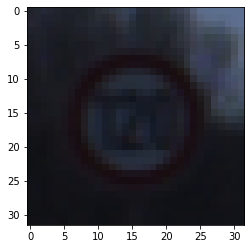

In [9]:
# Display image of a random sample in the dataset
index = np.random.randint(1, len(X_train))

plt.imshow(X_train[index])
print("image label={}".format(y_train[index]))

## Image Pre-processing

1. Converting to grayscale (The colors in the images are not important for the model we want to build)
2. Histogram Equalization (Standardizes lighting on all the images)
3. Normalization (Normalizes pixel values between 0 and 1)

In [10]:
# shuffle the data
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

In [11]:
def preprocessing(img):
  # convert to gray scale
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # Applying histogram equalization
  img = cv2.equalizeHist(img)

  # Normalization
  img = img/255

  return img

In [12]:
X_train_preprocessed = np.array(list(map(preprocessing, X_train)))
X_validation_preprocessed = np.array(list(map(preprocessing, X_validation)))
X_test_preprocessed = np.array(list(map(preprocessing, X_test)))

In [13]:
X_train_preprocessed = X_train_preprocessed.reshape(34799, 32, 32, 1)
X_test_preprocessed = X_test_preprocessed.reshape(12630, 32, 32, 1)
X_validation_preprocessed = X_validation_preprocessed.reshape(4410, 32, 32, 1)

In [14]:
print(X_train_preprocessed.shape)
print(X_test_preprocessed.shape)
print(X_validation_preprocessed.shape)

(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)


The '1' as the last parameter signifies that it is in grayscale format.

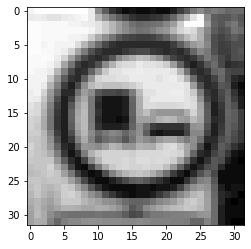

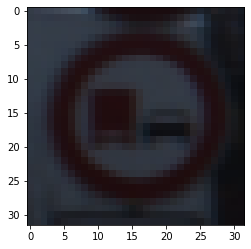

In [15]:
# Display image of a random sample in the pre-processed dataset
index = np.random.randint(1, len(X_train))

plt.imshow(X_train_preprocessed[index].squeeze(), cmap='gray')
plt.figure()

plt.imshow(X_train[index].squeeze())

## Build Deep Convolution Neural Network Model

In [16]:
model = Sequential()

# add the convolutional layer
# filters, size of filters, input_shape, activation_function
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(32, 32, 1)))

# pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# place a dropout layer
model.add(Dropout(0.25))

# add another convolutional layer
model.add(Conv2D(64, (5, 5), activation='relu'))

# pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the image to 1 dimensional array
model.add(Flatten())

# add a dense layer: amount of nodes, activation
model.add(Dense(256, activation='relu'))

# place a dropout layer
# 0.5 drop out rate is recommended, half input nodes will be dropped at each update
model.add(Dropout(0.5))

# defining the output layer of out network
model.add(Dense(43, activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0

In [18]:
# compile our model
model.compile(Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [20]:
# fit with training data
history = model.fit(X_train_preprocessed, y_train, batch_size=500, epochs=50, verbose=1, validation_data=(X_validation_preprocessed, y_validation))

Epoch 1/50
70/70 [==============================] - 2s 20ms/step - loss: 0.2949 - accuracy: 0.9117 - val_loss: 0.3119 - val_accuracy: 0.9029
Epoch 2/50
70/70 [==============================] - 1s 19ms/step - loss: 0.2818 - accuracy: 0.9168 - val_loss: 0.3035 - val_accuracy: 0.9050
Epoch 3/50
70/70 [==============================] - 1s 19ms/step - loss: 0.2769 - accuracy: 0.9205 - val_loss: 0.2973 - val_accuracy: 0.9057
Epoch 4/50
70/70 [==============================] - 1s 16ms/step - loss: 0.2727 - accuracy: 0.9215 - val_loss: 0.2974 - val_accuracy: 0.9052
Epoch 5/50
70/70 [==============================] - 1s 18ms/step - loss: 0.2676 - accuracy: 0.9219 - val_loss: 0.2894 - val_accuracy: 0.9086
Epoch 6/50
70/70 [==============================] - 1s 18ms/step - loss: 0.2608 - accuracy: 0.9226 - val_loss: 0.2874 - val_accuracy: 0.9093
Epoch 7/50
70/70 [==============================] - 1s 17ms/step - loss: 0.2575 - accuracy: 0.9238 - val_loss: 0.2833 - val_accuracy: 0.9120
Epoch 8/50
70

## Evaluate Performance of the Model

In [21]:
score = model.evaluate(X_test_preprocessed, y_test)
print('Test accuracy', score[1])

395/395 [==============================] - 2s 5ms/step - loss: 0.2841 - accuracy: 0.9249
Test accuracy 0.9248614311218262


In [22]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0.5, 0, 'epochs')

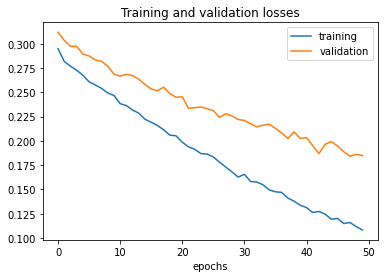

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Training and validation losses')
plt.xlabel('epochs')

Text(0.5, 0, 'epochs')

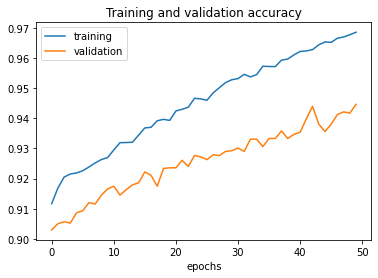

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Training and validation accuracy')
plt.xlabel('epochs')

In [26]:
prediction = np.argmax(model.predict(X_test_preprocessed), axis=-1)
y_true_label = y_test

395/395 [==============================] - 1s 3ms/step


<AxesSubplot:>

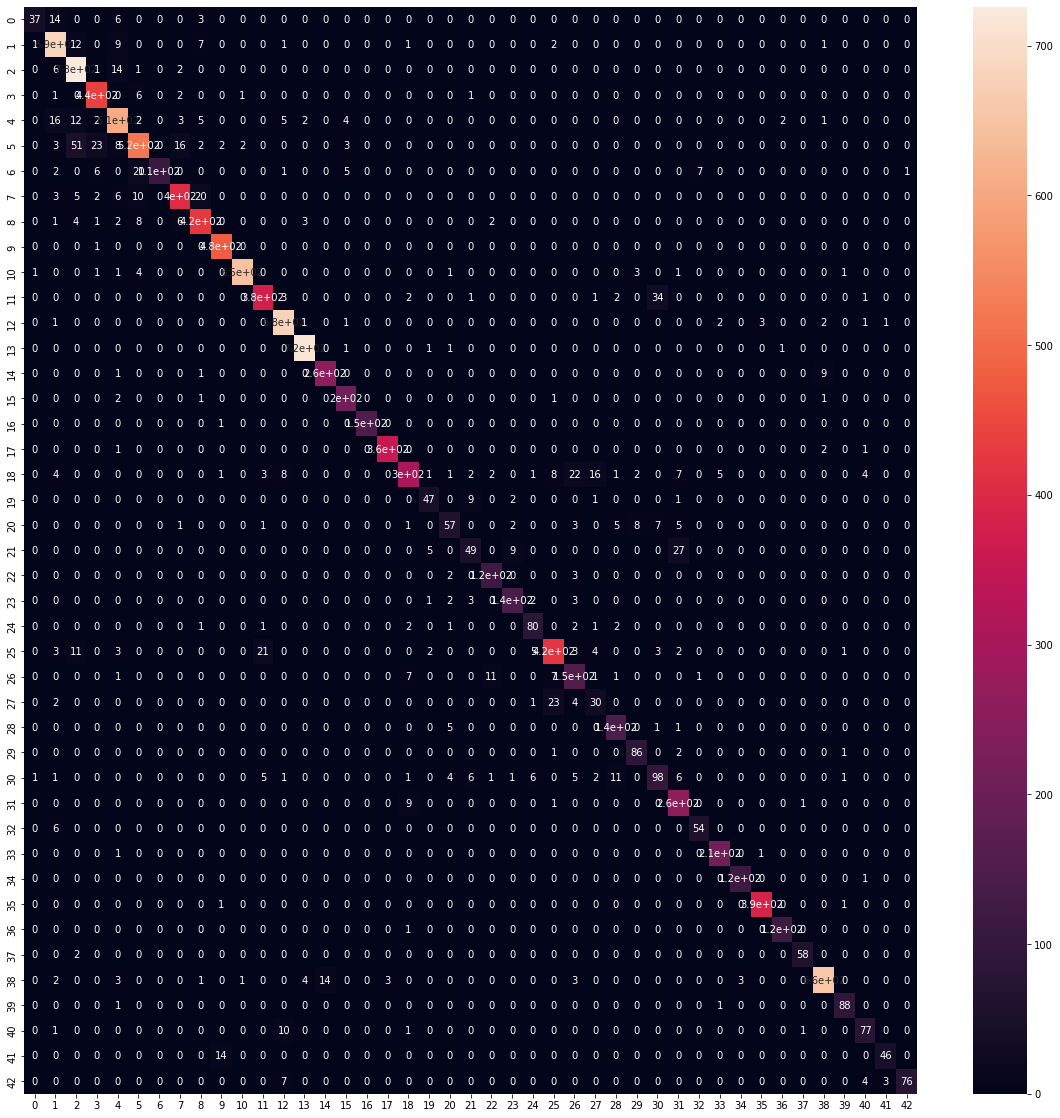

In [27]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_true_label, prediction)
plt.figure(figsize=(20,20))
sns.heatmap(matrix, annot=True)

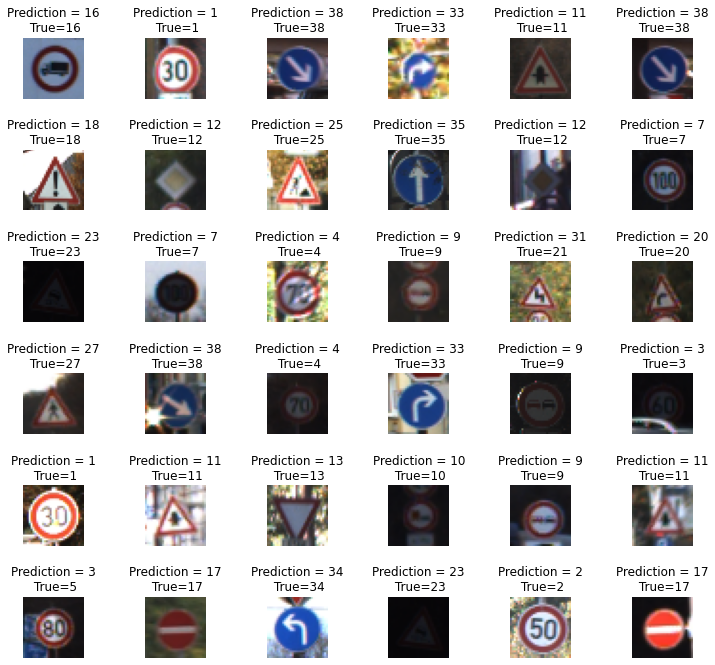

In [28]:
L = 6
W = 6
fig, axes = plt.subplots(L, W, figsize=(12, 12))
axes = axes.ravel()

for i in range(0, L*W):
  axes[i].imshow(X_test[i])
  axes[i].set_title('Prediction = {}\n True={}'.format(prediction[i], y_true_label[i]))
  axes[i].axis('off')

plt.subplots_adjust(wspace=1)

In [29]:
model.save('traffic_signs_classification_model.h5')